# Scenario Discovery
This notebook identifies critical scenarios that affect flood risk management policies, helping to understand the conditions under which these policies will be effective or fail.

In [1]:
# Load the libraries
from ema_workbench import load_results, ema_logging
from ema_workbench.analysis import prim, pairs_plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from ema_workbench.analysis import parcoords
from scipy.spatial.distance import pdist, squareform

In [2]:
# Import the results from the exploratory modelling with the zero policy
data = './data/exploratory_results_40000_zero_policy.tar.gz'

In [3]:
# Define the KPIs

KPIs = ['Expected Annual Damage', 'Expected Number of Deaths', 'RfR Investment Costs',
            'Dike Investment Costs','Evacuation Costs', 'Total Investment Costs']

# main KPI is Expected Number of Deaths
main_KPI = 'Expected Number of Deaths'

In [4]:
# Load the libraries
# Load the results and convert outcomes to DataFrame
experiments, outcomes = load_results(data)
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

In [5]:
# since dike investment costs, rfr investment costs and evacuation costs are 0, we can remove them
# Remove costs columns from outcomes dataframe
outcomes_without_costs = outcomes.drop(columns=['RfR Investment Costs', 'Dike Investment Costs', 
                                                    'Evacuation Costs', 'Total Investment Costs'])

**The objective of the delta commission is : "How can the Delta comission ensure quality of life for dutch citizens in a 100 years and reinforce flood management defences, while keeping within the budget allocated to the delta fund. While bringing together the perspectives of the various stakeholders across local ,regional and national level of governance.**

Expected Number of Deaths: This is the most critical KPI as it directly measures the impact on human life and safety, which is the highest priority in ensuring quality of life. 

Expected Annual Damage: While this is also important, it is more related to economic impacts and property damage, which indirectly affects quality of life.

## 2. PRIM

Scenario discovery is an essential step in understanding the range of plausible future conditions that could affect the outcomes of flood risk management policies. For the Delta Commission, this process is particularly valuable as it helps to identify the most critical scenarios that could impact the effectiveness and efficiency of flood defense strategies.

The Patient Rule Induction Method (PRIM) algorithm was chosen for scenario discovery due to its ability to handle high-dimensional data and identify combinations of input parameters that result in particular outcomes. PRIM is well-suited for discovering regions of the input space where a particular outcome of interest, such as the number of deaths, is prevalent. This method is especially useful in the context of deep uncertainty, where traditional scenario planning methods may fall short (Bryant & Lempert, 2010).


In [6]:
# Combine experiments and outcomes
# note: the costs are not taken into consideration becasue they are 0.
results = pd.concat([experiments, outcomes], axis=1)

In [7]:
# define uncertanties 
uncertainties = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']

In [8]:
# Separate features (x) and outcomes (y)
x = results.loc[:, uncertainties]
y = outcomes[main_KPI]

 Given the Delta Commission’s main objective to ensure the quality of life for Dutch citizens, there are a made a few decisions:
  - Prioritized meeting specific coverage and density thresholds.
  - 90th percentile of Expected Number of Deaths:
    - Coverage threshold of 0.8 met.
    - Density value was relatively low (0.612).
  - 80th percentile of Expected Number of Deaths:
    - Increased density significantly (0.880).
    - Potential boxes contained more interesting cases.
  - Prioritized higher number of interesting cases over the absolute highest number of deaths.
  - Captured a more comprehensive set of scenarios relevant to the Commission's objectives.

In [9]:
# So, the 80th percentile is used
eighty_quantile = y.quantile(0.8)
# Ensure y is binary
y_binary = (y > eighty_quantile).astype(int).values

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

# By setting the threshold to 0.75, the PRIM algorithm is instructed to find boxes 
# where at least 75% of the data points within the box are greater than the 80th percentile.
# This helps ensure that the identified boxes are highly relevant and contain a significant proportion of the desired outcomes.

# 0.75 is the max threshold that still gives boxes
prim_alg = prim.Prim(x, y_binary, threshold=0.75, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] 40000 points remaining, containing 8000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0984, coverage: 0.492, density: 1.0 restricted_dimensions: 3


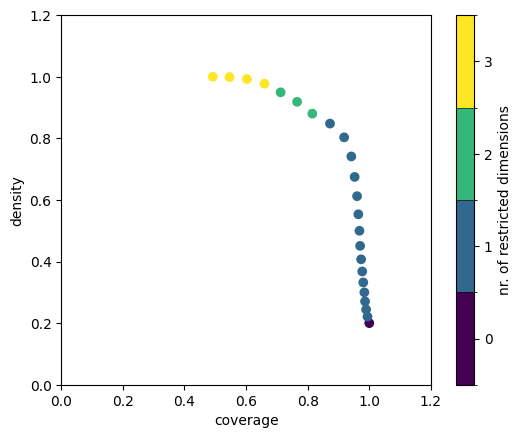

In [11]:
box1.show_tradeoff()
plt.show()

Density (y-axis): Represents the proportion of scenarios that are relevant to high expected number of deaths. Higher density indicates that the box is mostly composed of cases with high expected Number of Deaths.

Coverage (x-axis): Shows the proportion of all relevant cases captured by the scenario. Higher coverage means the scenario includes a greater fraction of all potential cases of interest.

Bryant and Lempert (2010) suggest aiming for a balance between coverage and density to ensure that the identified scenarios are both representative of the instances of interest and sufficiently distinct from the non-interesting instances.

Kwakkel et al. (2016) recommend setting initial thresholds and then adjusting based on the specific problem and the nature of the data. Common starting points might be:

Coverage: 0.8 or higher (meaning the box should cover at least 80% of the interesting instances).
Density: 0.6 or higher (meaning at least 60% of the instances within the box should be interesting instances).

In [12]:
# look at the cases where coverage is higher than 0.8 and density is higher than 0.6
potentials = box1.peeling_trajectory
potentials = potentials[(potentials.coverage > 0.8)
                         & (potentials.density > 0.6)]
potentials

,coverage,density,id,k,mass,mean,n,res_dim
11,0.960375,0.612191,11,7683,0.313750,0.612191,12550,1
12,0.952500,0.674635,12,7620,0.282375,0.674635,11295,1
13,0.941750,0.741171,13,7534,0.254125,0.741171,10165,1
14,0.918375,0.803126,14,7347,0.228700,0.803126,9148,1
15,0.872500,0.847808,15,6980,0.205825,0.847808,8233,1
16,0.815125,0.880146,16,6521,0.185225,0.880146,7409,2


In [13]:
chosen_box = potentials[potentials.density == potentials.density.max()]
chosen_box_id = int(chosen_box.iloc[0].name)
chosen_box_id

16

In [14]:
chosen_box

,coverage,density,id,k,mass,mean,n,res_dim
16,0.815125,0.880146,16,6521,0.185225,0.880146,7409,2


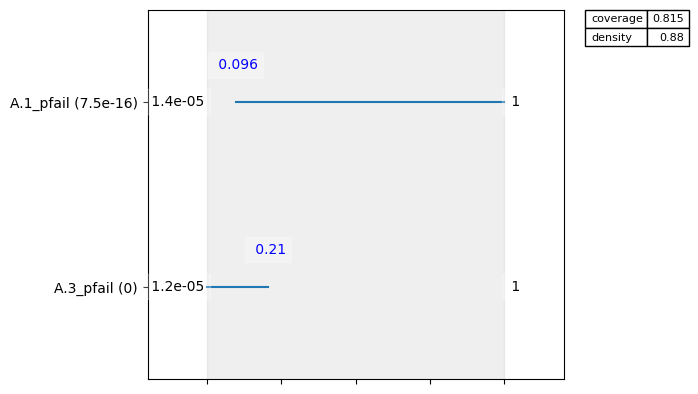

In [15]:
box1.select(chosen_box_id)
box1.inspect(style='graph')
plt.show()

### Interpretation of PRIM Results

The PRIM analysis provides insight into the most critical uncertainties affecting flood risk scenarios. The visualization focuses on two key parameters: **A.1_pfail** and **A.3_pfail**. These parameters represent the probabilities that the dikes at locations A.1 and A.3 will withstand the hydraulic load.

**Most Important Uncertainties**:
- **A.1_pfail**: The probability that the dike at location A.1 will withstand the hydraulic load.
- **A.3_pfail**: The probability that the dike at location A.3 will withstand the hydraulic load.

### Parameters and Their Constraints

Each row in the plot represents a parameter included in the identified box of scenarios:
- **A.1_pfail**: This parameter is being analyzed to understand its influence on the scenario outcomes.
  - **Range**: The horizontal bar shows the range within which the parameter values fall for the scenarios included in this box. The constrained range (shaded portion) indicates the values that define the box. For **A.1_pfail**, the range is from approximately $1.4 \times 10^{-5}$ to 1, indicating that scenarios with probabilities of withstanding the hydraulic load within this range are significant.
  - **Blue Number (0.096)**: Represents the constrained range start point.
  - **Endpoint (1)**: Indicates the endpoint of the constraint on the parameter.

- **A.3_pfail**: Similarly, this parameter's range is from approximately $1.2 \times 10^{-5}$ to 1.
  - **Blue Number (0.21)**: Represents the constrained range start point.
  - **Endpoint (1)**: Indicates the endpoint of the constraint on the parameter.

### Interpretation of Parameter Influence
- **A.1_pfail**: The range from $1.4 \times 10^{-5}$ to 1 suggests that scenarios with probabilities of withstanding the hydraulic load within this range are significant for this box. The relatively wide range indicates a broad set of conditions under which the dike at A.1 might withstand the load.
- **A.3_pfail**: The range from $1.2 \times 10^{-5}$ to 1 indicates that higher probabilities of withstanding the hydraulic load for the dike at A.3 are critical for defining this scenario. The constrained range start point at 0.21 suggests that probabilities above this value are particularly significant.

### Coverage and Density
- **Coverage (0.815)**: Approximately 81.5% of the potential high-risk scenarios are captured by this box. This high coverage level suggests that the identified box includes a significant portion of relevant cases.
- **Density (0.88)**: A density of 0.88 means that approximately 88% of the cases within this box meet the criteria for the outcome of interest. This high density indicates that the identified scenarios are predominantly high-risk, making this a precise and specific scenario for further analysis.

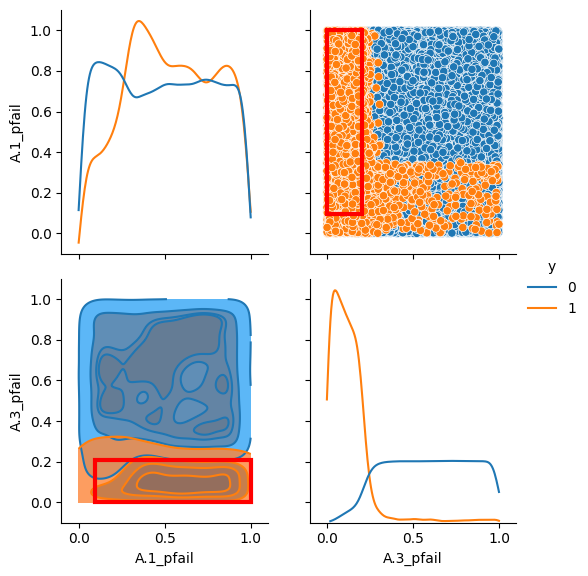

In [16]:
# select a specific box 
box1.select(chosen_box_id)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

The scatter plots and density plots illustrate the distribution of high-risk (orange) and low-risk (blue) outcomes concerning the probabilities that the dikes at locations A.1 and A.3 will withstand the hydraulic load (pfail).

- **Top-left plot (A.1_pfail)**: The density plot shows that high-risk outcomes (orange line) are more likely at lower probabilities of withstanding the hydraulic load for A.1, with a significant presence around the lower range values.
- **Top-right plot (A.1_pfail vs. A.3_pfail)**: The scatter plot indicates that high-risk outcomes (orange points) are clustered in the lower left quadrant, suggesting that combined low probabilities of withstanding the hydraulic load at A.1 and A.3 contribute significantly to high-risk scenarios.
- **Bottom-left plot (A.3_pfail vs. A.1_pfail)**: The contour plot shows that high-risk outcomes are predominantly located at low values of A.3_pfail, particularly when A.1_pfail is also low.
- **Bottom-right plot (A.3_pfail)**: The density plot for A.3_pfail shows that high-risk outcomes (orange line) are more prevalent at lower probabilities of withstanding the hydraulic load for A.3, with a sharp peak at very low values.

Overall, the plots indicate that high-risk outcomes are associated with low probabilities of dike resistance across A.1 and A.3. This suggests that the likelihood of high-risk scenarios increases significantly when both dikes have lower probabilities of withstanding the hydraulic load.

In [17]:
# Inspect the parameter limits from the chosen box.
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.007799,"{1.0, 10.0, 1.5}",0.096155,30.000261,"{1.0, 10.0, 1.5}",0.000002,30.003451,"{1.0, 10.0, 1.5}",0.000012,30.006324,"{1.0, 10.0, 1.5}",0.000002,30.007344,"{1.0, 10.0, 1.5}",0.000007,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.993660,"{1.0, 10.0, 1.5}",0.999981,349.997535,"{1.0, 10.0, 1.5}",0.999979,349.995840,"{1.0, 10.0, 1.5}",0.205823,349.992530,"{1.0, 10.0, 1.5}",0.999978,349.996187,"{1.0, 10.0, 1.5}",0.999978,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [18]:
# Interpret the limits of the box
# The limits of the box are the minimum and maximum values of the parameters that define the box.

print("Uncertainties limits of the box:")
for param, (lower_bound, upper_bound) in limits.items():
    print(f"{param}: {lower_bound} to {upper_bound}")

Uncertainties limits of the box:
A.0_ID flood wave shape: 0 to 132
A.1_Bmax: 30.00779931639029 to 349.99366000747875
A.1_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.1_pfail: 0.09615480699965226 to 0.9999812138737576
A.2_Bmax: 30.00026069203341 to 349.99753472319105
A.2_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.2_pfail: 1.7849447651314935e-06 to 0.9999790707176208
A.3_Bmax: 30.00345147275937 to 349.9958399227369
A.3_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.3_pfail: 1.1688779985953123e-05 to 0.20582283598982884
A.4_Bmax: 30.00632414624865 to 349.9925298167018
A.4_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.4_pfail: 1.8282914351359171e-06 to 0.9999779041462512
A.5_Bmax: 30.00734425693272 to 349.996187035818
A.5_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.5_pfail: 7.409756835223017e-06 to 0.9999782786433188
discount rate 0: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5, 4.5}
discount rate 1: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5, 4.5}
discount rate 2: {1.5, 2.5, 3.5, 4.5} to {1.5,

In [19]:
# Usage of limits
# Filter the results of all experiments to only include the experiments that fall within the box limits
# Only filter on the uncertainties that influence the box
results_box = results[
    (results['A.1_pfail'] >= limits['A.1_pfail'][0]) & (results['A.1_pfail'] <= limits['A.1_pfail'][1]) &
    (results['A.3_pfail'] >= limits['A.3_pfail'][0]) & (results['A.3_pfail'] <= limits['A.3_pfail'][1])
]

results_box.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
3,125,323.748619,1.0,0.348941,162.310684,1.5,0.119125,79.367400,10.0,0.001792,...,0,3,Zero Policy,dikesnet,3.621184e+09,0,0.0,0.0,4.726881,0.0
5,37,286.824604,1.5,0.282438,222.710392,1.0,0.466771,92.315255,1.0,0.081138,...,0,5,Zero Policy,dikesnet,3.065381e+09,0,0.0,0.0,3.277519,0.0
22,16,134.323752,1.0,0.602434,196.924355,1.5,0.302187,343.165892,1.5,0.059988,...,0,22,Zero Policy,dikesnet,2.043054e+09,0,0.0,0.0,3.547420,0.0
42,55,184.601087,1.5,0.669015,215.668512,1.5,0.467809,230.624844,1.0,0.107615,...,0,42,Zero Policy,dikesnet,2.378107e+09,0,0.0,0.0,3.321307,0.0
52,3,112.468853,10.0,0.703181,62.322361,1.0,0.553291,173.485977,10.0,0.101375,...,0,52,Zero Policy,dikesnet,1.832792e+09,0,0.0,0.0,3.365987,0.0


In [20]:
print(f'There are {results_box.shape[0]} scenarios in the PRIM box.')

There are 7409 scenarios in the PRIM box.


In [21]:
# Drop the non numeric columns
results_box_numeric = results_box.drop(columns=['policy', 'model'])

# export the results box into a csv file
results_box_numeric.to_csv('./data/prim_results_box.csv')

In [22]:
# Identify the worst-case scenario of the box
worst_case_index = results_box_numeric[main_KPI].idxmax()
worst_case = results_box_numeric.loc[[worst_case_index]]

Following the initial selection of high-risk scenarios through the Patient Rule Induction Method (PRIM), which identified key scenarios based on the 'Expected Number of Deaths' and critical dike failure probabilities (A.1_pfail and A.3_pfail), there has been employed a robust method to ensure the diversity of the selected scenarios for detailed analysis. This approach aimed to comprehensively cover the scenario space identified by PRIM, which demonstrated significant risk implications for flood management strategies.

After normalizing the outcomes of 'Expected Number of Deaths' and 'Expected Annual Damage' (the KPIs)using a standard scaler to ensure fair distance calculations, pairwise distances between all scenarios are calculated. The costs are not taken into consideration because the experiments were done with no policy intervention. This process generated a comprehensive distance matrix, encapsulating the relative differences between each scenario in a standardized outcome space, facilitating the selection of a diverse set of scenarios.

To select the most diverse scenarios from the matrix, a systematic selection process was implemented:
- Initial Scenario: This began by randomly selecting an initial scenario from the pool, ensuring that the starting point was unbiased.
- Diverse Addition: Iteratively, scenarios that were the furthest away from the already selected scenarios based on the minimum distance in the distance matrix were added. This step was repeated until we reached the desired number of scenarios.

This method of selecting scenarios based on maximizing the minimum distance ensures that each new scenario added to the selection pool offers the most distinct perspective from those already chosen. This diversity is crucial for capturing a broad and representative sample of potential high-risk outcomes and supports comprehensive policy analysis and decision-making under deep uncertainty.
These diverse scenarios, characterized by their varied levels of expected deaths and damage, provide a robust foundation for further policy development and testing in the Policy Discovery phase. Each scenario represents unique conditions and outcomes that could arise under different flood events, allowing for the development of strategies that are not only effective under typical conditions but are also resilient to less probable, high-impact events.


In [37]:
# Normalize the outcomes for fair distance calculation
scaler = StandardScaler()
normalized_outcomes = scaler.fit_transform(results_box_numeric[['Expected Number of Deaths', 'Expected Annual Damage']])

# Calculate pairwise distances
distance_matrix = squareform(pdist(normalized_outcomes, metric='euclidean'))

# Function to select most diverse scenarios
def select_diverse_scenarios(distance_matrix, num_scenarios):
    # Start with a random scenario
    selected_indices = [np.random.choice(range(distance_matrix.shape[0]))]
    for _ in range(num_scenarios - 1):
        min_distances = distance_matrix[selected_indices].min(axis=0)
        next_index = min_distances.argmax()
        selected_indices.append(next_index)
    return selected_indices

In [38]:
# Select 4-5 most diverse scenarios
num_scenarios = 4
selected_indices = select_diverse_scenarios(distance_matrix, num_scenarios)
subset_scenarios = results_box_numeric.iloc[selected_indices]

In [39]:
# Include worst-case scenario explicitly if not already in the subset
if worst_case['scenario'].values[0] not in subset_scenarios['scenario'].values:
    subset_scenarios = pd.concat([subset_scenarios, worst_case], ignore_index=True)

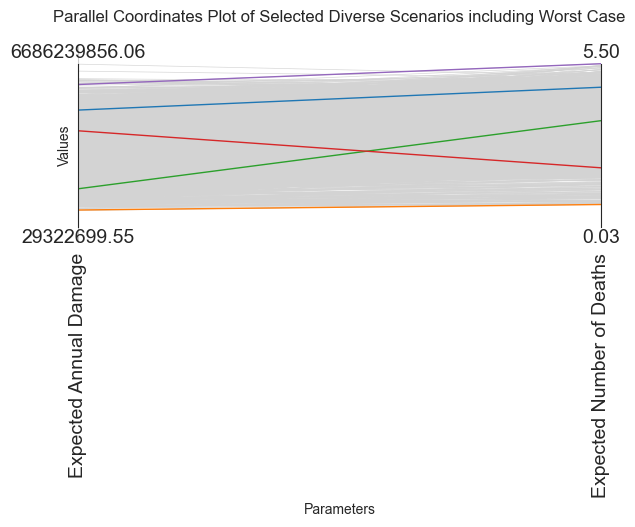

In [41]:
# Create Parallel Coordinates Plot using parcoords
limits = parcoords.get_limits(outcomes_without_costs)
axes = parcoords.ParallelAxes(limits)

# Plot all scenarios with light grey lines
axes.plot(results_box, color='lightgrey', lw=0.5, alpha=0.9)

# Plot selected scenarios with distinct colors
for i, scenario in enumerate(subset_scenarios.index):
    axes.plot(subset_scenarios.loc[scenario, :], color=sns.color_palette()[i], lw=1)

plt.title('Parallel Coordinates Plot of Selected Diverse Scenarios including Worst Case\n')
plt.xlabel('Parameters')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [28]:
# Change the form of the selected scenarios dataframe to be able to use them in next steps 
# For further analysis, we don't need the outcomes and levers because the scenarios are a combination of uncertainties only
# In next steps we will use the scenarios to test combinations of levers (policy) and look what it does with the outcomes. 

#drop the outcomes
subset_scenarios = subset_scenarios.drop(columns=['Expected Annual Damage',
       'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs',
       'Expected Number of Deaths', 'Total Investment Costs'])

In [29]:
# drop the levers
subset_scenarios = subset_scenarios.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'])

In [30]:
# The scenario column needs to be renamed to Run ID 
subset_scenarios = subset_scenarios.rename(columns={'scenario': 'Run ID'})

In [33]:
# Save the selected scenarios for further analysis
subset_scenarios.to_csv('./data/selected_scenarios.csv', index=False)